In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!rm -r "/content/vehicle_dataset/"
!rm -r "/content/database/"
!cp '/content/drive/MyDrive/MIRCV/vehicle_dataset.zip' .
!cp '/content/drive/MyDrive/MIRCV/database.zip' .
!unzip -q "/content/vehicle_dataset.zip"
!unzip -q "/content/database.zip"
!rm "/content/vehicle_dataset.zip"
!rm "/content/database.zip"

rm: cannot remove '/content/vehicle_dataset/': No such file or directory
rm: cannot remove '/content/database/': No such file or directory


In [3]:
import glob
import os
import numpy as np
import PIL
from IPython.display import display
from tqdm.notebook import tqdm
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
import math
from IPython.display import display
from tensorflow.keras.regularizers import l2
from tqdm.notebook import tqdm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import PIL
from tensorflow.keras.optimizers import RMSprop, Adam


np.random.seed(42)
tf.random.set_seed(42)

In [4]:
DATA_SET="/content/database"
TEST_SET="/content/vehicle_dataset/test"
BATCH_SIZE=128
CLASSES=9
IMAGE_SIZE=(224, 224)

In [5]:
!cp '/content/drive/MyDrive/MIRCV/model/vgg16_finetuned_2_best.h5' .
!cp '/content/drive/MyDrive/MIRCV/model/vgg16_pretrained_1_best.h5' .
!cp '/content/drive/MyDrive/MIRCV/model/vgg19_finetuned_2_best.h5' .
!cp '/content/drive/MyDrive/MIRCV/model/vgg19_pretrained_1_best.h5' .

In [6]:
def get_all_labels(dataset):
    number_of_examples = len(dataset.filenames)
    number_of_generator_calls = math.ceil(number_of_examples / (1.0 * BATCH_SIZE)) 
    test_labels = []

    for i in tqdm(range(0,int(number_of_generator_calls))):
      test_labels.extend(np.array(dataset[i][1]))
    return np.int_(test_labels)

In [7]:
datagen = image.ImageDataGenerator(
            preprocessing_function=preprocess_input)



dataset = datagen.flow_from_directory(
            DATA_SET,
            target_size=IMAGE_SIZE,
            batch_size=BATCH_SIZE,
            classes={'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, '9': 8 ,'10': 9,},
            class_mode='sparse',
            shuffle=False)



test_dataset = datagen.flow_from_directory(
        TEST_SET,
        shuffle=False,
        class_mode='sparse',
        classes={'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, '9': 8},
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE)

Found 74325 images belonging to 10 classes.
Found 11579 images belonging to 9 classes.


In [ ]:
 print(dataset.class_indices)

{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, '9': 8, '10': 9}


(128, 224, 224, 3) (128,)
float32 -123.68 151.061


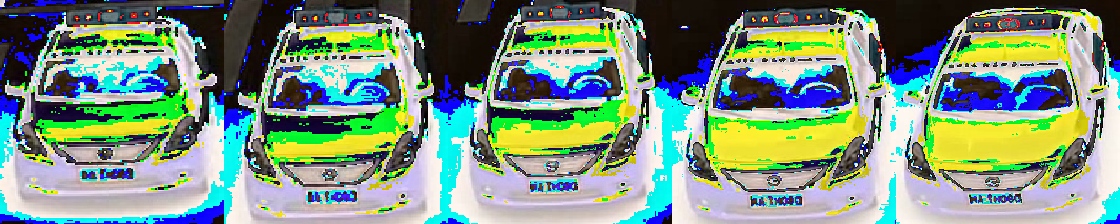

In [8]:
batch = next(iter(dataset))  
images, labels = batch
print(images.shape, labels.shape)

# inspect data type
#images = images.numpy()
print(images.dtype, images.min(), images.max())  # float32, [0, 255]

# show some images
sample_images = np.hstack(images[:5])  # stack 5 images horizontally
sample_images = sample_images.astype(np.uint8)  # PIL wants uint8
sample_images = PIL.Image.fromarray(sample_images)  # to PIL image
display(sample_images)  # show it

In [9]:
import json

try:
    import redis
except ImportError:
    redis = None

__all__ = ['storage']


def storage(storage_config, index):
    """ Given the configuration for storage and the index, return the
    configured storage instance.
    """
    if 'dict' in storage_config:
        return InMemoryStorage(storage_config['dict'])
    elif 'redis' in storage_config:
        storage_config['redis']['db'] = index
        return RedisStorage(storage_config['redis'])
    else:
        raise ValueError("Only in-memory dictionary and Redis are supported.")


class BaseStorage(object):
    def __init__(self, config):
        """ An abstract class used as an adapter for storages. """
        raise NotImplementedError

    def keys(self):
        """ Returns a list of binary hashes that are used as dict keys. """
        raise NotImplementedError

    def set_val(self, key, val):
        """ Set `val` at `key`, note that the `val` must be a string. """
        raise NotImplementedError

    def get_val(self, key):
        """ Return `val` at `key`, note that the `val` must be a string. """
        raise NotImplementedError

    def append_val(self, key, val):
        """ Append `val` to the list stored at `key`.
        If the key is not yet present in storage, create a list with `val` at
        `key`.
        """
        raise NotImplementedError

    def get_list(self, key):
        """ Returns a list stored in storage at `key`.
        This method should return a list of values stored at `key`. `[]` should
        be returned if the list is empty or if `key` is not present in storage.
        """
        raise NotImplementedError


class InMemoryStorage(BaseStorage):
    def __init__(self, config):
        self.name = 'dict'
        self.storage = dict()

    def keys(self):
        return self.storage.keys()

    def set_val(self, key, val):
        self.storage[key] = val

    def get_val(self, key):
        return self.storage[key]

    def append_val(self, key, val):
        self.storage.setdefault(key, []).append(val)

    def get_list(self, key):
        return self.storage.get(key, [])


class RedisStorage(BaseStorage):
    def __init__(self, config):
        if not redis:
            raise ImportError("redis-py is required to use Redis as storage.")
        self.name = 'redis'
        self.storage = redis.StrictRedis(**config)

    def keys(self, pattern="*"):
        return self.storage.keys(pattern)

    def set_val(self, key, val):
        self.storage.set(key, val)

    def get_val(self, key):
        return self.storage.get(key)

    def append_val(self, key, val):
        self.storage.rpush(key, json.dumps(val))

    def get_list(self, key):
        return self.storage.lrange(key, 0, -1)

In [10]:
import os
import json
import numpy as np
from random import randint
!pip install itertools
from itertools import *

class LSHash(object):
    """ LSHash implments locality sensitive hashing using random projection for
    input vectors of dimension `input_dim`.
    Attributes:
    :param hash_size:
        The length of the resulting binary hash in integer. E.g., 32 means the
        resulting binary hash will be 32-bit long.
    :param input_dim:
        The dimension of the input vector. E.g., a grey-scale picture of 30x30
        pixels will have an input dimension of 900.
    :param num_hashtables:
        (optional) The number of hash tables used for multiple lookups.
    :param storage_config:
        (optional) A dictionary of the form `{backend_name: config}` where
        `backend_name` is the either `dict` or `redis`, and `config` is the
        configuration used by the backend. For `redis` it should be in the
        format of `{"redis": {"host": hostname, "port": port_num}}`, where
        `hostname` is normally `localhost` and `port` is normally 6379.
    :param matrices_filename:
        (optional) Specify the path to the compressed numpy file ending with
        extension `.npz`, where the uniform random planes are stored, or to be
        stored if the file does not exist yet.
    :param overwrite:
        (optional) Whether to overwrite the matrices file if it already exist
    """

    def __init__(self, hash_size, input_dim, num_hashtables=1,method=None,
                 storage_config=None, matrices_filename=None, overwrite=False):

        self.hash_size = hash_size
        self.input_dim = input_dim
        self.num_hashtables = num_hashtables
        self.method=method

        if storage_config is None:
            storage_config = {'dict': None}
        self.storage_config = storage_config

        if matrices_filename and not matrices_filename.endswith('.npz'):
            raise ValueError("The specified file name must end with .npz")
        self.matrices_filename = matrices_filename
        self.overwrite = overwrite

        self._init_uniform_planes()
        self._init_hashtables()

    def _init_uniform_planes(self):
        """ Initialize uniform planes used to calculate the hashes
        if file `self.matrices_filename` exist and `self.overwrite` is
        selected, save the uniform planes to the specified file.
        if file `self.matrices_filename` exist and `self.overwrite` is not
        selected, load the matrix with `np.load`.
        if file `self.matrices_filename` does not exist and regardless of
        `self.overwrite`, only set `self.uniform_planes`.
        """

        if "uniform_planes" in self.__dict__:
            return

        if self.matrices_filename:
            file_exist = os.path.isfile(self.matrices_filename)
            if file_exist and not self.overwrite:
                try:
                    npzfiles = np.load(self.matrices_filename)
                except IOError:
                    print("Cannot load specified file as a numpy array")
                    raise
                else:
                    npzfiles = sorted(npzfiles.items(), key=lambda x: x[0])
                    self.uniform_planes = [t[1] for t in npzfiles]
            else:
                self.uniform_planes = [self._generate_uniform_planes()
                                       for _ in range(self.num_hashtables)]
                try:
                    np.savez_compressed(self.matrices_filename,
                                        *self.uniform_planes)
                except IOError:
                    print("IOError when saving matrices to specificed path")
                    raise
        else:
            self.uniform_planes = [self._generate_uniform_planes()
                                   for _ in range(self.num_hashtables)]

    def _init_hashtables(self):
        """ Initialize the hash tables such that each record will be in the
        form of "[storage1, storage2, ...]" """

        self.hash_tables = [storage(self.storage_config, i)
                            for i in range(self.num_hashtables)]

    def _generate_uniform_planes(self):
        """ Generate uniformly distributed hyperplanes and return it as a 2D
        numpy array.
        """
        if self.method==None:
          return (np.random.normal(0,2,size=(self.hash_size, self.input_dim)),np.random.uniform(0,4,size=self.hash_size))
        else:
          return np.random.randint(self.input_dim, size=(self.hash_size))

    def _hash(self, planes, input_point):
        """ Generates the binary hash for `input_point` and returns it.
        :param planes:
            The planes are random uniform planes with a dimension of
            `hash_size` * `input_dim`.
        :param input_point:
            A Python tuple or list object that contains only numbers.
            The dimension needs to be 1 * `input_dim`.
        """

        try:
            if self.method==None:
              input_point = np.array(input_point)  # for faster dot product
              #projections = np.dot(planes[0], input_point)
              #print(projections)
              projections = np.ceil((np.dot(planes[0], input_point)+planes[1])/4)
              #print(projections)
              #projections = (np.dot(planes[0], input_point)+planes[1])/4
              
            else:
              input_point = np.array(input_point)
              projections = input_point[planes] 
        except TypeError as e:
            print("""The input point needs to be an array-like object with
                  numbers only elements""")
            raise
        except ValueError as e:
            print("""The input point needs to be of the same dimension as
                  `input_dim` when initializing this LSHash instance""", e)
            raise
        else:
            return "".join([str(i) for i in projections])

    def _as_np_array(self, json_or_tuple):
        """ Takes either a JSON-serialized data structure or a tuple that has
        the original input points stored, and returns the original input point
        in numpy array format.
        """
        if isinstance(json_or_tuple, str):
            # JSON-serialized in the case of Redis
            try:
                # Return the point stored as list, without the extra data
                tuples = json.loads(json_or_tuple)[0]
            except TypeError:
                print("The value stored is not JSON-serilizable")
                raise
        else:
            # If extra_data exists, `tuples` is the entire
            # (point:tuple, extra_data). Otherwise (i.e., extra_data=None),
            # return the point stored as a tuple
            tuples = json_or_tuple

        if isinstance(tuples[0], tuple):
            # in this case extra data exists
            return np.asarray(tuples[0])

        elif isinstance(tuples, (tuple, list)):
            try:
                return np.asarray(tuples)
            except ValueError as e:
                print("The input needs to be an array-like object", e)
                raise
        else:
            raise TypeError("query data is not supported")

    def index(self, input_point, extra_data=None):
        """ Index a single input point by adding it to the selected storage.
        If `extra_data` is provided, it will become the value of the dictionary
        {input_point: extra_data}, which in turn will become the value of the
        hash table. `extra_data` needs to be JSON serializable if in-memory
        dict is not used as storage.
        :param input_point:
            A list, or tuple, or numpy ndarray object that contains numbers
            only. The dimension needs to be 1 * `input_dim`.
            This object will be converted to Python tuple and stored in the
            selected storage.
        :param extra_data:
            (optional) Needs to be a JSON-serializable object: list, dicts and
            basic types such as strings and integers.
        """

        if isinstance(input_point, np.ndarray):
            input_point = input_point.tolist()

        if extra_data:
            value = (tuple(input_point), extra_data)
        else:
            value = tuple(input_point)
        for i, table in enumerate(self.hash_tables):
          table.append_val(self._hash(self.uniform_planes[i], input_point),
                             value)

    def query(self, query_point, num_results=None, distance_func=None):
        """ Takes `query_point` which is either a tuple or a list of numbers,
        returns `num_results` of results as a list of tuples that are ranked
        based on the supplied metric function `distance_func`.
        :param query_point:
            A list, or tuple, or numpy ndarray that only contains numbers.
            The dimension needs to be 1 * `input_dim`.
            Used by :meth:`._hash`.
        :param num_results:
            (optional) Integer, specifies the max amount of results to be
            returned. If not specified all candidates will be returned as a
            list in ranked order.
        :param distance_func:
            (optional) The distance function to be used. Currently it needs to
            be one of ("hamming", "euclidean", "true_euclidean",
            "centred_euclidean", "cosine", "l1norm"). By default "euclidean"
            will used.
        """
        
        candidates = set()
        if not distance_func:
            distance_func = "euclidean"

        if distance_func == "euclidean":
          d_func = LSHash.euclidean_dist_square
        elif distance_func == "hamming":
          d_func = LSHash.hamming_dist
        elif distance_func == "true_euclidean":
          d_func = LSHash.euclidean_dist
        elif distance_func == "centred_euclidean":
          d_func = LSHash.euclidean_dist_centred
        elif distance_func == "cosine":
          d_func = LSHash.cosine_dist
        elif distance_func == "l1norm":
          d_func = LSHash.l1norm_dist
        else:
            raise ValueError("The distance function name is invalid.")
        for i, table in enumerate(self.hash_tables):
          binary_hash = self._hash(self.uniform_planes[i], query_point)
          candidates.update(table.get_list(binary_hash))
        #print(len(candidates))
        # rank candidates by distance function
        candidates=[val for val in islice(candidates, 20000) ]
        candidates = [(ix, d_func(query_point, self._as_np_array(ix)))
                      for ix in candidates]


        
        if distance_func == "cosine":
            candidates.sort(key=lambda x: x[1],reverse=True)
        else:
            candidates.sort(key=lambda x: x[1])
        return candidates[:num_results] if num_results else candidates, len(candidates)

    ### distance functions

    @staticmethod
    def hamming_dist(bitarray1, bitarray2):
        #xor_result = bitarray(bitarray1) ^ bitarray(bitarray2)
        return np.count_nonzero(bitarray1!=bitarray2)

    @staticmethod
    def euclidean_dist(x, y):
        """ This is a hot function, hence some optimizations are made. """
        diff = np.array(x) - y
        return np.sqrt(np.dot(diff, diff))

    @staticmethod
    def euclidean_dist_square(x, y):
        """ This is a hot function, hence some optimizations are made. """
        diff = np.array(x) - y
        return np.dot(diff, diff)

    @staticmethod
    def euclidean_dist_centred(x, y):
        """ This is a hot function, hence some optimizations are made. """
        diff = np.mean(x) - np.mean(y)
        return np.dot(diff, diff)

    @staticmethod
    def l1norm_dist(x, y):
        return sum(abs(x - y))

    @staticmethod
    def cosine_dist(x, y):
        return np.dot(x, y)

ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools


In [11]:
opt_vgg16_fe = models.load_model('vgg16_pretrained_1_best.h5')
opt_vgg16_ft = models.load_model('vgg16_finetuned_2_best.h5')
opt_vgg19_fe = models.load_model('vgg19_pretrained_1_best.h5')
opt_vgg19_ft = models.load_model('vgg19_finetuned_2_best.h5')

In [12]:
def prova(dataset):
    number_of_examples = len(dataset.filenames)
    number_of_generator_calls = math.ceil(number_of_examples / (1.0 * BATCH_SIZE)) 
    X=[]
    y=[]
    for i in tqdm(range(0,int(number_of_generator_calls))):
      X.extend(np.array(dataset[i][0]))
      y.extend(np.array(dataset[i][1]))
    y=[int(intero) for intero in y]
    return X,y

In [13]:

test_images, test_labels = prova(test_dataset)
test_images = np.array(test_images)
test_labels = np.array(test_labels)


In [68]:
from PIL import Image, ImageDraw, ImageOps
# utility function to extract and normalize features

def extract_features_nogenerator(feature_extractor, images):
  features = feature_extractor.predict(images, batch_size=BATCH_SIZE)
  features = sklearn.preprocessing.normalize(features)
  return features


# utility function to perform kNN search
def search(query_features, db_features, k):
  scores = np.dot(query_features, db_features.T)  # compute cosine scores
  ranks = np.argsort(-scores, axis=1)  # order for descending score (NOTE the minus sign)
  topk = ranks[:, :k]  # get the top-k indices for each query
  n_queries = len(query_features)
  topk_scores = scores[np.arange(n_queries).reshape(-1, 1), topk]  # get the top-k scores for each query
  return topk, topk_scores


# utility to resize, pad, and write score on images
preview_size = 80
def process_images(image, score, is_relevant):
  x = image.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  # to uint8 [0, 255]
  #image = ((image - 1) * 127.5).astype(np.uint8)
  image=x
  # add a red/green flag
  color = (0, 255, 0) if is_relevant else (255, 0, 0)
  flag = np.full((10, 224, 3), fill_value=color, dtype=image.dtype)
  image = np.concatenate((image, flag), axis=0)

  # resize
  image = Image.fromarray(image).convert('RGBA')
  image.thumbnail((preview_size, preview_size))  # use PIL to resize the image

  # draw score
  draw = ImageDraw.Draw(image)
  draw.text((3, preview_size - 12), f'{score:.2f}', anchor='lt', fill=(255, 255, 255, 255))

  # pad the image with transparency
  image = ImageOps.expand(image, 5, fill=(0, 0, 0, 0))
  image = np.array(image)
  return image

# use np.vectorize to apply custom functions to numpy arrays
np_process_image = np.vectorize(process_images, signature='(h,w,c),(),()->(h1,w1,c1)')


def compute_ap_at_k(ranked_relevance, k):
  # each row in ranked_relevance is a boolean array that indicates whether that 
  # retrieved element is relevant for the query 
  total_relevant_items = ranked_relevance.sum(axis=1)
  # Precision@i for each query, i.e. the number of relevant items @i divided by i
  prec_at_i = ranked_relevance[:, :k].cumsum(axis=1) / np.arange(1, k + 1) 
  # sum of prec_at_i only for relevant, divide for total number of relevant items (for each query)
  aps = (ranked_relevance[:, :k] * prec_at_i).sum(axis=1) / total_relevant_items 

  return aps


# utility function to draw knn results for multiple queries
def show_results(images, scores, is_relevant):
  # images has shape (n_queries, k, H, W, C)
  images = np_process_image(images, scores, is_relevant)
  images = np.concatenate(images, axis=1)  # concatenate queries vertically
  images = np.concatenate(images, axis=1)  # concatenate results horizontally
  
  display(Image.fromarray(images))
def show_query(images):
  x = images.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')

  display(Image.fromarray(x))

In [15]:
def create_lsh_index(features,labels,lsh=None):
    for i,feature in enumerate(tqdm(features)):
      lsh.index(feature,str(int(labels[i])))
    print("index created")


In [71]:
import random 
import time
def evaluate_lsh(model,query_images,query_labels,lsh, k=None,distance="cosine"):
  query_features = extract_features_nogenerator(model, query_images)
  if distance == "hamming":
    data_features_median=np.median(query_features,axis=0)
    query_features=query_features>data_features_median[None,:]
    query_features=1*query_features

  find_labels=[]
  find_candidates=[]
  times_not_optimized = []

  for query in tqdm(query_features):
    start_time = time.time()
    labels,candidates=lsh.query(query,k,distance)
    end_time = time.time()
    find_labels.append(labels)
    find_candidates.append(candidates)
    times_not_optimized.append(end_time - start_time)
  
  ranked_labels=[[int(d[0][1]) for d in l] for l in find_labels]
  ranked_scores=[[d[1] for d in l] for l in find_labels]
  ranked_scores=np.asarray(ranked_scores)
  k = len(db_labels) if k is None else k
  ranked_relevance = ranked_labels == query_labels.reshape(-1, 1)
  ## computation of mAP@k
  aps = compute_ap_at_k(ranked_relevance, k)
  #print("Time for queries:",times_not_optimized)
  print("Time for queries(mean):",np.mean(np.array(times_not_optimized)))
  #print(f'AP@{k} for each Query:', aps)
  aps=np.where(~np.isnan(aps), aps, 0)
  print(f'mAP@{k}:', np.mean(aps))
  print(f'Length for candidates(mean) :', np.mean(np.array(find_candidates)))
  
  #k = min(k, 15)  # don't show more than 15 images in colab

  
  #topk_scores = ranked_scores[:,:k]
  #topk_is_relevant = ranked_relevance[:,:k]
  
  """ Sklearn meanAP (normalizes score to consider only k retrieved elements)  
  aps = [sklearn.metrics.average_precision_score(l, s) for l,s in zip(topk_is_relevant, topk_scores)]
  print('APs per Query:', aps)
  print('mAP:', np.mean(aps))
  """

  #show_results(topk_images, topk_scores, topk_is_relevant)
  return np.mean(np.array(times_not_optimized)), np.mean(aps), np.mean(np.array(find_candidates))
  

In [17]:
import pickle
def extract_features(feature_extractor,dataset,namefile):
  features = feature_extractor.predict(dataset,verbose=1)
  features = sklearn.preprocessing.normalize(features)
  print(features.shape)
  number_of_examples = len(dataset.filenames)
  number_of_generator_calls = math.ceil(number_of_examples / (1.0 * BATCH_SIZE)) 
  y=get_all_labels(dataset)
  with open("/content/drive/MyDrive/MIRCV/featuresextracted/"+namefile+".pickle",'wb') as features_file:
    pickle.dump((features,y,dataset.filenames),features_file,protocol=pickle.HIGHEST_PROTOCOL)
  print(y.shape)
  return features,y

In [18]:
def load_pickle(namefile):
  with open("/content/drive/MyDrive/MIRCV/featuresextracted"+namefile+".pickle", 'rb') as features_file:
    features,labels,_ = pickle.load(features_file)
  return features,labels

In [19]:
def write_metric(filename,distance,g,h,k,time_query,map_query,len_candidates):
  with open(filename, 'a') as testwritefile:
    testwritefile.write(distance+";"+str(g)+";"+str(h)+";"+str(k)+";"+str(len_candidates)+";"+str(time_query)+";"+str(map_query)+"\n")

In [ ]:
n_queries = 50
k = 100
# np.concatenate([images for images, _ in test_dataset])  # get only the images

# query_indexes = [78, 80, 89, 23, 20]
# query_indexes = [14, 78, 79, 12, 18]
query_indexes = [14, 78,  2, 18,  9]
np.random.seed(11)
query_indexes = np.random.choice(len(test_images), n_queries, replace=False)  # get 10 queries at random
query_images = test_images[query_indexes]
query_labels = test_labels[query_indexes]

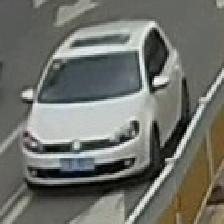

3


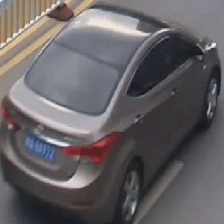

0


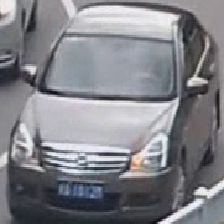

0


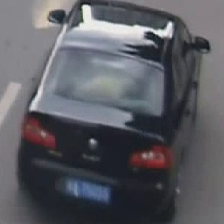

0


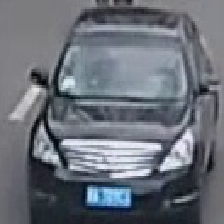

0


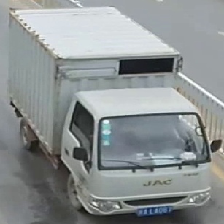

7


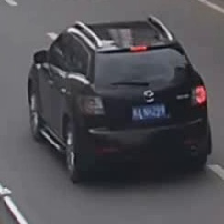

1


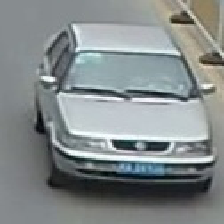

0


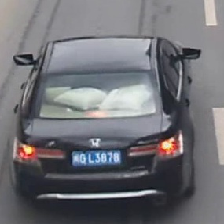

0


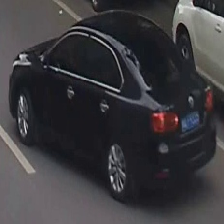

0


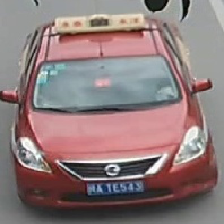

0


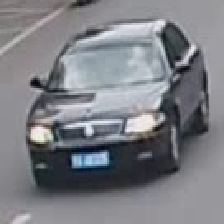

0


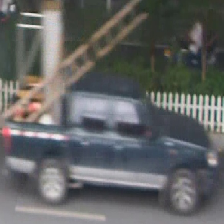

5


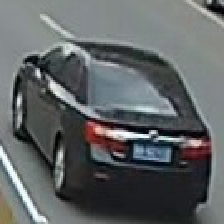

0


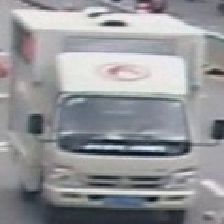

7


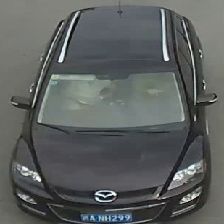

1


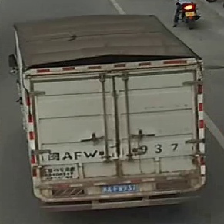

7


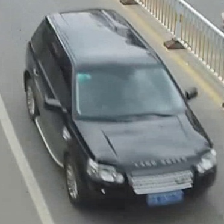

1


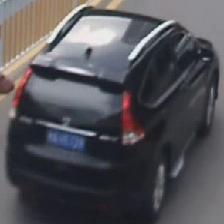

1


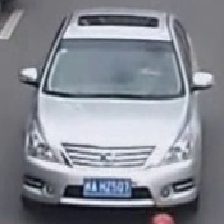

0


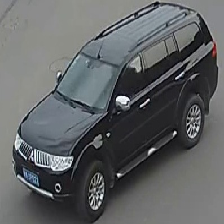

1


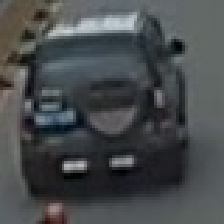

1


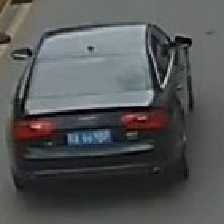

0


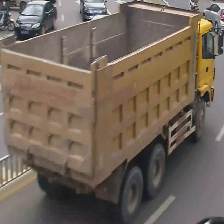

7


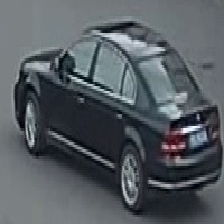

0


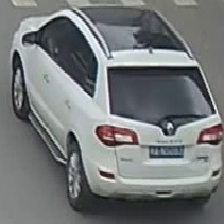

1


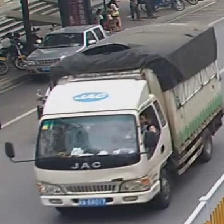

7


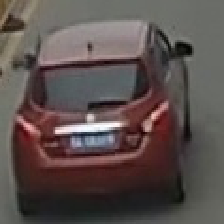

3


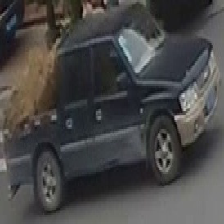

5


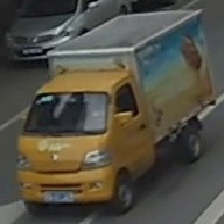

7


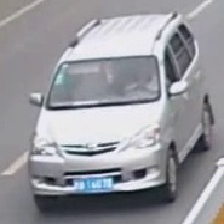

1


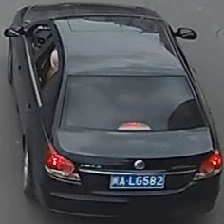

0


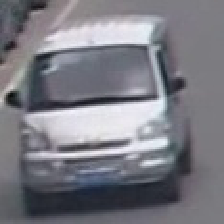

2


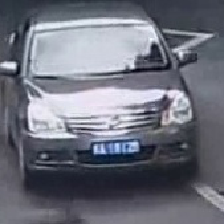

0


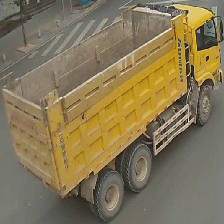

7


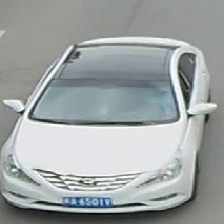

0


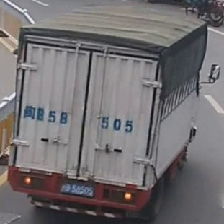

7


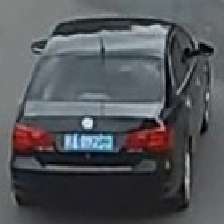

0


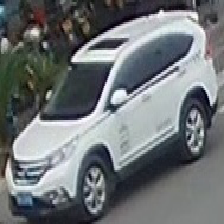

1


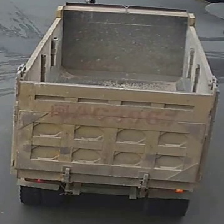

7


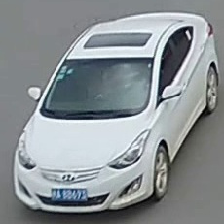

0


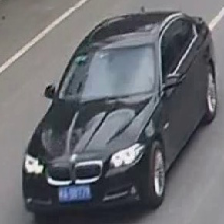

0


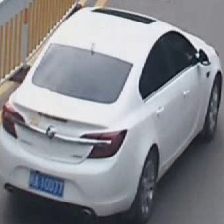

0


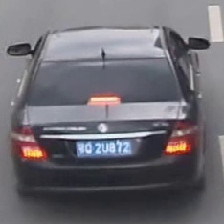

0


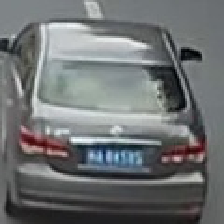

0


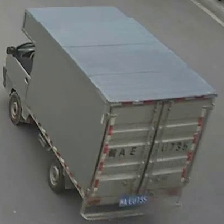

7


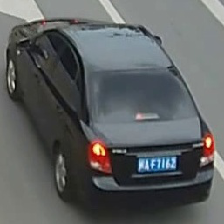

0


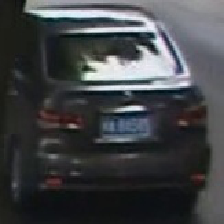

0


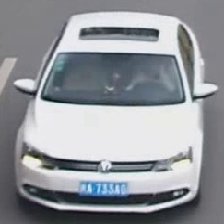

0


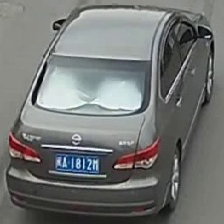

0


In [ ]:
for i,image in enumerate(query_images):
  show_query(image)
  print(query_labels[i])

In [ ]:
def start_index(data_features,data_labels,model,query_images,query_labels,filename,distances=['cosine','euclidean']):
  for distance in distances:
    for G in [1,2,3,4,5]:
      for H in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
        lsh = LSHash(H,data_features.shape[1],G,None if distance!="hamming" else distance)
        create_lsh_index(data_features,data_labels,lsh)
        print("-------Start-----------")
        print("k={}; g={}; h={}".format(100,G,H))    
        try:   
          times_query,map_query,len_candidates=evaluate_lsh(model,query_images,query_labels,lsh, 100,distance)
          #write_metric(filename,distance,G,H,100,times_query,map_query,len_candidates)
        except Exception:
          pass


## Inizio valutazione indice- fine tuned vgg16 [Alberto]

In [ ]:
finetuned_feature_extractor = Model(inputs=opt_vgg16_ft.input, outputs=opt_vgg16_ft.get_layer('classifier_hidden').output)

In [ ]:
## cambiare ""finetuned_features"" con qualcos'altro
data_features,data_labels=extract_features(finetuned_feature_extractor,dataset,"vgg16_finetuned_features_hid")

581/581 [==============================] - 297s 468ms/step
(74325, 9)



(74325,)


In [ ]:
#attenzione al nome
data_features,data_labels=load_pickle("/vgg16_finetuned_features_hid")
print(data_features.shape[1])
#filename="/content/drive/MyDrive/MIRCV/metrics/vgg16_tuned.txt"

9


In [ ]:
start_index(data_features,data_labels,finetuned_feature_extractor,query_images,query_labels,"")



index created
-------Start-----------
k=100; g=1; h=1



Time for queries(mean): 0.1488506269454956
mAP@100: 0.6303753884959651
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=1; h=2



Time for queries(mean): 0.12185293197631836
mAP@100: 0.6587047778073023
Length for candidates(mean) : 18246.58



index created
-------Start-----------
k=100; g=1; h=3



Time for queries(mean): 0.09619929790496826
mAP@100: 0.66889068415246
Length for candidates(mean) : 14978.68



index created
-------Start-----------
k=100; g=1; h=4


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=5



Time for queries(mean): 0.08980002880096435
mAP@100: 0.6548130699520692
Length for candidates(mean) : 13953.48



index created
-------Start-----------
k=100; g=1; h=6


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=7


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=8


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=9


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=10


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=11


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=12


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=13


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=14


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=15


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=1



Time for queries(mean): 0.15461935043334962
mAP@100: 0.6328180519452169
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=2; h=2



Time for queries(mean): 0.1387653875350952
mAP@100: 0.6557021418838568
Length for candidates(mean) : 18908.94



index created
-------Start-----------
k=100; g=2; h=3



Time for queries(mean): 0.12642065048217774
mAP@100: 0.6643236410924045
Length for candidates(mean) : 18261.24



index created
-------Start-----------
k=100; g=2; h=4



Time for queries(mean): 0.12245134830474853
mAP@100: 0.6541830800483902
Length for candidates(mean) : 17200.02



index created
-------Start-----------
k=100; g=2; h=5



Time for queries(mean): 0.10979275703430176
mAP@100: 0.6711390203177838
Length for candidates(mean) : 15433.38



index created
-------Start-----------
k=100; g=2; h=6



Time for queries(mean): 0.10206835269927979
mAP@100: 0.6593180772688636
Length for candidates(mean) : 14863.64



index created
-------Start-----------
k=100; g=2; h=7


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=8


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=9



Time for queries(mean): 0.09387394905090332
mAP@100: 0.6689321834791474
Length for candidates(mean) : 13229.34



index created
-------Start-----------
k=100; g=2; h=10


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=11


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=12


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=13



Time for queries(mean): 0.0915460729598999
mAP@100: 0.6687974538522465
Length for candidates(mean) : 12628.16



index created
-------Start-----------
k=100; g=2; h=14


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=15



Time for queries(mean): 0.08745235919952393
mAP@100: 0.6689010552565243
Length for candidates(mean) : 12280.74



index created
-------Start-----------
k=100; g=3; h=1



Time for queries(mean): 0.1819315242767334
mAP@100: 0.6309527596974474
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=3; h=2



Time for queries(mean): 0.15423497676849365
mAP@100: 0.6368517206264763
Length for candidates(mean) : 19971.38



index created
-------Start-----------
k=100; g=3; h=3



Time for queries(mean): 0.13640336513519288
mAP@100: 0.6630125904934335
Length for candidates(mean) : 18401.06



index created
-------Start-----------
k=100; g=3; h=4



Time for queries(mean): 0.13748926162719727
mAP@100: 0.6642501723092774
Length for candidates(mean) : 17435.96



index created
-------Start-----------
k=100; g=3; h=5



Time for queries(mean): 0.12523536682128905
mAP@100: 0.6678076635841741
Length for candidates(mean) : 17257.44



index created
-------Start-----------
k=100; g=3; h=6



Time for queries(mean): 0.0999515962600708
mAP@100: 0.6680461122442157
Length for candidates(mean) : 13184.4



index created
-------Start-----------
k=100; g=3; h=7



Time for queries(mean): 0.10462728977203369
mAP@100: 0.6677879104026999
Length for candidates(mean) : 14126.42



index created
-------Start-----------
k=100; g=3; h=8



Time for queries(mean): 0.10359732627868652
mAP@100: 0.6683038307793158
Length for candidates(mean) : 13562.44



index created
-------Start-----------
k=100; g=3; h=9



Time for queries(mean): 0.0912543535232544
mAP@100: 0.6684706795932134
Length for candidates(mean) : 12481.22



index created
-------Start-----------
k=100; g=3; h=10


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=11



Time for queries(mean): 0.09844913959503174
mAP@100: 0.6682952956439807
Length for candidates(mean) : 13512.34



index created
-------Start-----------
k=100; g=3; h=12



Time for queries(mean): 0.08479523181915283
mAP@100: 0.6661088986696706
Length for candidates(mean) : 11551.18



index created
-------Start-----------
k=100; g=3; h=13


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=14



Time for queries(mean): 0.09912930011749267
mAP@100: 0.6672806078434783
Length for candidates(mean) : 13174.6



index created
-------Start-----------
k=100; g=3; h=15


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=4; h=1



Time for queries(mean): 0.20116284370422363
mAP@100: 0.6320235026113796
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=4; h=2



Time for queries(mean): 0.1711658000946045
mAP@100: 0.6379943070167446
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=4; h=3



Time for queries(mean): 0.1561435604095459
mAP@100: 0.6626997987840234
Length for candidates(mean) : 19458.96



index created
-------Start-----------
k=100; g=4; h=4



Time for queries(mean): 0.12507606983184816
mAP@100: 0.666626809525182
Length for candidates(mean) : 15910.96



index created
-------Start-----------
k=100; g=4; h=5



Time for queries(mean): 0.13825897216796876
mAP@100: 0.6668033543865494
Length for candidates(mean) : 17226.08



index created
-------Start-----------
k=100; g=4; h=6



Time for queries(mean): 0.11726010799407958
mAP@100: 0.6690902178453997
Length for candidates(mean) : 14900.54



index created
-------Start-----------
k=100; g=4; h=7



Time for queries(mean): 0.1031167221069336
mAP@100: 0.6681336128830115
Length for candidates(mean) : 12893.84



index created
-------Start-----------
k=100; g=4; h=8



Time for queries(mean): 0.11015374660491943
mAP@100: 0.6682267581423109
Length for candidates(mean) : 14278.98



index created
-------Start-----------
k=100; g=4; h=9



Time for queries(mean): 0.1006101894378662
mAP@100: 0.6696870126174097
Length for candidates(mean) : 12740.98



index created
-------Start-----------
k=100; g=4; h=10



Time for queries(mean): 0.09949305534362793
mAP@100: 0.6674908907716663
Length for candidates(mean) : 12874.06



index created
-------Start-----------
k=100; g=4; h=11


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=4; h=12



Time for queries(mean): 0.10402461528778076
mAP@100: 0.6681559764145925
Length for candidates(mean) : 13508.4



index created
-------Start-----------
k=100; g=4; h=13



Time for queries(mean): 0.09955796718597412
mAP@100: 0.668649065975814
Length for candidates(mean) : 12657.46



index created
-------Start-----------
k=100; g=4; h=14


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=4; h=15



Time for queries(mean): 0.10866480827331543
mAP@100: 0.6683865550994794
Length for candidates(mean) : 13730.76



index created
-------Start-----------
k=100; g=5; h=1



Time for queries(mean): 0.20444867610931397
mAP@100: 0.6321609720971066
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=5; h=2



Time for queries(mean): 0.19244059562683105
mAP@100: 0.6392208934090486
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=5; h=3



Time for queries(mean): 0.15841153621673584
mAP@100: 0.6471336989625759
Length for candidates(mean) : 18401.04



index created
-------Start-----------
k=100; g=5; h=4



Time for queries(mean): 0.1523939037322998
mAP@100: 0.6689781890560625
Length for candidates(mean) : 17969.42



index created
-------Start-----------
k=100; g=5; h=5



Time for queries(mean): 0.14809224128723145
mAP@100: 0.6655839313135766
Length for candidates(mean) : 17458.16



index created
-------Start-----------
k=100; g=5; h=6



Time for queries(mean): 0.11996180057525635
mAP@100: 0.6686018903211469
Length for candidates(mean) : 14501.56



index created
-------Start-----------
k=100; g=5; h=7



Time for queries(mean): 0.11967360019683838
mAP@100: 0.66707217428249
Length for candidates(mean) : 14477.76



index created
-------Start-----------
k=100; g=5; h=8


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=9


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=10



Time for queries(mean): 0.12125597953796387
mAP@100: 0.6676175685642913
Length for candidates(mean) : 13914.9



index created
-------Start-----------
k=100; g=5; h=11



Time for queries(mean): 0.10351462841033936
mAP@100: 0.669240654364602
Length for candidates(mean) : 13048.34



index created
-------Start-----------
k=100; g=5; h=12


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=13


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=14


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=15


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=1



Time for queries(mean): 0.17135489940643311
mAP@100: 0.7070188115478016
Length for candidates(mean) : 18959.54



index created
-------Start-----------
k=100; g=1; h=2



Time for queries(mean): 0.15009414672851562
mAP@100: 0.6966939146496217
Length for candidates(mean) : 16665.56



index created
-------Start-----------
k=100; g=1; h=3



Time for queries(mean): 0.1579279088973999
mAP@100: 0.7255212025456694
Length for candidates(mean) : 18186.0



index created
-------Start-----------
k=100; g=1; h=4



Time for queries(mean): 0.11899757862091065
mAP@100: 0.7339685795062324
Length for candidates(mean) : 13855.06



index created
-------Start-----------
k=100; g=1; h=5


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=6



Time for queries(mean): 0.10467669010162353
mAP@100: 0.7292197419561159
Length for candidates(mean) : 12268.58



index created
-------Start-----------
k=100; g=1; h=7


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=8


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=9


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=10


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=11


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=12


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=13


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=14


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=15


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=1



Time for queries(mean): 0.21250105857849122
mAP@100: 0.6821521827604751
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=2; h=2



Time for queries(mean): 0.17138269424438476
mAP@100: 0.694980264252182
Length for candidates(mean) : 17651.48



index created
-------Start-----------
k=100; g=2; h=3



Time for queries(mean): 0.1708247184753418
mAP@100: 0.7149963700721382
Length for candidates(mean) : 18425.32



index created
-------Start-----------
k=100; g=2; h=4



Time for queries(mean): 0.1537477207183838
mAP@100: 0.7132884690237272
Length for candidates(mean) : 16479.26



index created
-------Start-----------
k=100; g=2; h=5



Time for queries(mean): 0.1522677421569824
mAP@100: 0.7255963094913058
Length for candidates(mean) : 16577.24



index created
-------Start-----------
k=100; g=2; h=6



Time for queries(mean): 0.1241886281967163
mAP@100: 0.7269111537090354
Length for candidates(mean) : 14039.92



index created
-------Start-----------
k=100; g=2; h=7



Time for queries(mean): 0.12748514175415038
mAP@100: 0.7267022137329309
Length for candidates(mean) : 14205.18



index created
-------Start-----------
k=100; g=2; h=8



Time for queries(mean): 0.11172115325927734
mAP@100: 0.7268915064301017
Length for candidates(mean) : 12646.38



index created
-------Start-----------
k=100; g=2; h=9


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=10



Time for queries(mean): 0.11624351501464844
mAP@100: 0.7280421231467541
Length for candidates(mean) : 12947.34



index created
-------Start-----------
k=100; g=2; h=11



Time for queries(mean): 0.11072775363922119
mAP@100: 0.7278640063457533
Length for candidates(mean) : 12035.04



index created
-------Start-----------
k=100; g=2; h=12


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=13


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=14


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=15



Time for queries(mean): 0.11349113464355469
mAP@100: 0.7276968552152349
Length for candidates(mean) : 12545.26



index created
-------Start-----------
k=100; g=3; h=1



Time for queries(mean): 0.2207927656173706
mAP@100: 0.6838744504624846
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=3; h=2



Time for queries(mean): 0.20859899997711182
mAP@100: 0.6819313395384795
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=3; h=3



Time for queries(mean): 0.19119176864624024
mAP@100: 0.7085469243792055
Length for candidates(mean) : 19911.36



index created
-------Start-----------
k=100; g=3; h=4



Time for queries(mean): 0.1895514678955078
mAP@100: 0.711588892373299
Length for candidates(mean) : 19651.32



index created
-------Start-----------
k=100; g=3; h=5



Time for queries(mean): 0.14620179176330567
mAP@100: 0.7229435814893173
Length for candidates(mean) : 15282.2



index created
-------Start-----------
k=100; g=3; h=6



Time for queries(mean): 0.13884712219238282
mAP@100: 0.7271564760026458
Length for candidates(mean) : 14600.84



index created
-------Start-----------
k=100; g=3; h=7



Time for queries(mean): 0.15285170078277588
mAP@100: 0.7177353875869382
Length for candidates(mean) : 15547.66



index created
-------Start-----------
k=100; g=3; h=8


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=9


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=10


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=11


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=12


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=13


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=14


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=15


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=4; h=1



Time for queries(mean): 0.25172860622406007
mAP@100: 0.6844395297313858
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=4; h=2



Time for queries(mean): 0.20722008228302002
mAP@100: 0.7007819402999991
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=4; h=3



Time for queries(mean): 0.1964464282989502
mAP@100: 0.7194515134330183
Length for candidates(mean) : 19706.82



index created
-------Start-----------
k=100; g=4; h=4



Time for queries(mean): 0.1884860324859619
mAP@100: 0.7194512559535511
Length for candidates(mean) : 19080.86



index created
-------Start-----------
k=100; g=4; h=5



Time for queries(mean): 0.1521311092376709
mAP@100: 0.7249959212000714
Length for candidates(mean) : 14993.82



index created
-------Start-----------
k=100; g=4; h=6



Time for queries(mean): 0.14550017356872558
mAP@100: 0.7246804828138896
Length for candidates(mean) : 14863.14



index created
-------Start-----------
k=100; g=4; h=7



Time for queries(mean): 0.14841758251190185
mAP@100: 0.725129420644868
Length for candidates(mean) : 14717.42



index created
-------Start-----------
k=100; g=4; h=8



Time for queries(mean): 0.12866701126098634
mAP@100: 0.7265381870802672
Length for candidates(mean) : 13074.22



index created
-------Start-----------
k=100; g=4; h=9


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=4; h=10


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=4; h=11



Time for queries(mean): 0.12834996223449707
mAP@100: 0.7263630960628759
Length for candidates(mean) : 12977.66



index created
-------Start-----------
k=100; g=4; h=12


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=4; h=13



Time for queries(mean): 0.13518468379974366
mAP@100: 0.7318958536000097
Length for candidates(mean) : 13516.52



index created
-------Start-----------
k=100; g=4; h=14



Time for queries(mean): 0.12078177452087402
mAP@100: 0.7296205227272017
Length for candidates(mean) : 12659.2



index created
-------Start-----------
k=100; g=4; h=15


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=1



Time for queries(mean): 0.2742957592010498
mAP@100: 0.6827884232406302
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=5; h=2



Time for queries(mean): 0.22640786170959473
mAP@100: 0.6946946208916682
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=5; h=3



Time for queries(mean): 0.20699856281280518
mAP@100: 0.7010913127924744
Length for candidates(mean) : 19999.74



index created
-------Start-----------
k=100; g=5; h=4



Time for queries(mean): 0.19484045028686522
mAP@100: 0.7165857808104532
Length for candidates(mean) : 18658.16



index created
-------Start-----------
k=100; g=5; h=5



Time for queries(mean): 0.18263710498809815
mAP@100: 0.7154149413192121
Length for candidates(mean) : 17558.08



index created
-------Start-----------
k=100; g=5; h=6



Time for queries(mean): 0.16457221031188965
mAP@100: 0.7230010076456246
Length for candidates(mean) : 15637.7



index created
-------Start-----------
k=100; g=5; h=7



Time for queries(mean): 0.1439662456512451
mAP@100: 0.7247002112530856
Length for candidates(mean) : 14303.86



index created
-------Start-----------
k=100; g=5; h=8


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=9



Time for queries(mean): 0.15158388614654542
mAP@100: 0.7250705707716524
Length for candidates(mean) : 15145.64



index created
-------Start-----------
k=100; g=5; h=10



Time for queries(mean): 0.14411303520202637
mAP@100: 0.7258650974355024
Length for candidates(mean) : 13606.28



index created
-------Start-----------
k=100; g=5; h=11



Time for queries(mean): 0.13350485801696776
mAP@100: 0.7271970796859507
Length for candidates(mean) : 12890.84



index created
-------Start-----------
k=100; g=5; h=12


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=13


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=14


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=15


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
data_features_median=np.median(data_features,axis=0)
bitwise=data_features>data_features_median[None,:]
bitwise=1*bitwise

In [ ]:
start_index(bitwise,data_labels,finetuned_feature_extractor,query_images,query_labels,"",['hamming'])

        


index created
-------Start-----------
k=100; g=1; h=1



Time for queries(mean): 0.011399521827697753
mAP@100: 0.2717893594085732
Length for candidates(mean) : 567.5



index created
-------Start-----------
k=100; g=1; h=2



Time for queries(mean): 0.005815544128417969
mAP@100: 0.2911901731209583
Length for candidates(mean) : 283.62



index created
-------Start-----------
k=100; g=1; h=3


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=4


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=5


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=6


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=7


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=8


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=9


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=10


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=11


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=12


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=13


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=14


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=15


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=1



Time for queries(mean): 0.021944398880004882
mAP@100: 0.2706343537669212
Length for candidates(mean) : 851.72



index created
-------Start-----------
k=100; g=2; h=2



Time for queries(mean): 0.013387136459350586
mAP@100: 0.27319330082353505
Length for candidates(mean) : 422.74



index created
-------Start-----------
k=100; g=2; h=3



Time for queries(mean): 0.008143105506896973
mAP@100: 0.26281290379913463
Length for candidates(mean) : 253.74



index created
-------Start-----------
k=100; g=2; h=4



Time for queries(mean): 0.005934276580810547
mAP@100: 0.26295860907858076
Length for candidates(mean) : 195.82



index created
-------Start-----------
k=100; g=2; h=5


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=6


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=7


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=8


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=9


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=10


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=11


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=12


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=13


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=14


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=15


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=1



Time for queries(mean): 0.030511503219604493
mAP@100: 0.269448804567028
Length for candidates(mean) : 990.3



index created
-------Start-----------
k=100; g=3; h=2



Time for queries(mean): 0.017548742294311522
mAP@100: 0.26904084241634096
Length for candidates(mean) : 550.9



index created
-------Start-----------
k=100; g=3; h=3



Time for queries(mean): 0.01000882625579834
mAP@100: 0.258530826188753
Length for candidates(mean) : 225.02



index created
-------Start-----------
k=100; g=3; h=4



Time for queries(mean): 0.00814328670501709
mAP@100: 0.26420684309551945
Length for candidates(mean) : 241.3



index created
-------Start-----------
k=100; g=3; h=5



Time for queries(mean): 0.009169044494628907
mAP@100: 0.2703084612143543
Length for candidates(mean) : 301.16



index created
-------Start-----------
k=100; g=3; h=6


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=7



Time for queries(mean): 0.0064623022079467775
mAP@100: 0.26831199965612906
Length for candidates(mean) : 151.04



index created
-------Start-----------
k=100; g=3; h=8


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=9


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=10


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=11


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=12


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=13


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=14


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=15


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=4; h=1



Time for queries(mean): 0.040688395500183105
mAP@100: 0.2697155191235197
Length for candidates(mean) : 1047.74



index created
-------Start-----------
k=100; g=4; h=2



Time for queries(mean): 0.024513359069824218
mAP@100: 0.2704242148356586
Length for candidates(mean) : 602.8



index created
-------Start-----------
k=100; g=4; h=3



Time for queries(mean): 0.020369043350219728
mAP@100: 0.26950700286408336
Length for candidates(mean) : 580.54



index created
-------Start-----------
k=100; g=4; h=4



Time for queries(mean): 0.011086988449096679
mAP@100: 0.27171588479825864
Length for candidates(mean) : 315.06



index created
-------Start-----------
k=100; g=4; h=5



Time for queries(mean): 0.008531227111816406
mAP@100: 0.2692913453734428
Length for candidates(mean) : 255.24



index created
-------Start-----------
k=100; g=4; h=6


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=4; h=7


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=4; h=8


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=4; h=9


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=4; h=10



Time for queries(mean): 0.007442178726196289
mAP@100: 0.2652671210062898
Length for candidates(mean) : 161.88



index created
-------Start-----------
k=100; g=4; h=11


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=4; h=12


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=4; h=13


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=4; h=14


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=4; h=15


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=1



Time for queries(mean): 0.047105507850646974
mAP@100: 0.26979728609360804
Length for candidates(mean) : 988.24



index created
-------Start-----------
k=100; g=5; h=2



Time for queries(mean): 0.033657193183898926
mAP@100: 0.2696893099860295
Length for candidates(mean) : 849.62



index created
-------Start-----------
k=100; g=5; h=3



Time for queries(mean): 0.02179952144622803
mAP@100: 0.27063323323205724
Length for candidates(mean) : 544.44



index created
-------Start-----------
k=100; g=5; h=4



Time for queries(mean): 0.021705875396728514
mAP@100: 0.27057868421623466
Length for candidates(mean) : 614.98



index created
-------Start-----------
k=100; g=5; h=5



Time for queries(mean): 0.015153980255126953
mAP@100: 0.26636037807665086
Length for candidates(mean) : 362.6



index created
-------Start-----------
k=100; g=5; h=6



Time for queries(mean): 0.010009350776672364
mAP@100: 0.27039112494317036
Length for candidates(mean) : 198.32



index created
-------Start-----------
k=100; g=5; h=7



Time for queries(mean): 0.008442249298095703
mAP@100: 0.2714956254531751
Length for candidates(mean) : 160.8



index created
-------Start-----------
k=100; g=5; h=8


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=9


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=10


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=11


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=12


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=13


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=14


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=15


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray




## Inizio valutazione indice- feature extractor vgg16 [Alberto]


In [ ]:
new_classifier_feature_extractor = Model(inputs=opt_vgg16_fe.input, outputs=opt_vgg16_fe.get_layer('classifier_hidden').output)

In [ ]:
data_features,data_labels=extract_features(new_classifier_feature_extractor,dataset,"vgg16_feature_extractor_index")

In [ ]:
data_features,data_labels=load_pickle("/vgg16_feature_extractor_index")
filename="/content/drive/MyDrive/MIRCV/metrics/vgg16_extractor.txt"

In [ ]:
start_index(data_features,data_labels,new_classifier_feature_extractor,query_images,query_labels,filename)

In [ ]:
data_features_median=np.median(data_features,axis=0)
bitwise=data_features>data_features_median[None,:]
bitwise=1*bitwise

In [ ]:
start_index(data_features,data_labels,new_classifier_feature_extractor,query_images,query_labels,filename,['hamming'])

## Inizio valutazione indice- VGG16 [Yuli]

---



In [ ]:
pretrained_feature_extractor = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, pooling='avg')

In [ ]:
data_features,data_labels=extract_features(pretrained_feature_extractor,dataset,"vgg16_index")

In [ ]:
data_features,data_labels=load_pickle("/vgg16_index")
print(data_features.shape[1])
filename="/content/drive/MyDrive/MIRCV/metrics/vgg16.txt"

In [ ]:
start_index(data_features,data_labels,pretrained_feature_extractor,query_images,query_labels,filename)

In [ ]:
data_features_median=np.median(data_features,axis=0)
bitwise=data_features>data_features_median[None,:]
bitwise=1*bitwise

In [ ]:
start_index(bitwise,data_labels,pretrained_feature_extractor,query_images,query_labels,filename,['hamming'])

## Inizio valutazione indice- fine tuned vgg19 [Yuli]

In [ ]:
finetuned_feature_extractor = Model(inputs=opt_vgg19_ft.input, outputs=opt_vgg19_ft.get_layer('gap').output)

In [ ]:
data_features,data_labels=extract_features(finetuned_feature_extractor,dataset,"vgg19_finetuned_features")

581/581 [==============================] - 261s 450ms/step
(74325, 512)



(74325,)


In [ ]:
data_features,data_labels=load_pickle("/vgg19_finetuned_features")
print(data_features.shape[1])
filename="/content/drive/MyDrive/MIRCV/metrics/vgg19_tuned.txt"

512


In [ ]:
start_index(data_features,data_labels,finetuned_feature_extractor,query_images,query_labels,filename)


index created
-------Start-----------
k=100; g=1; h=1



Time for queries(mean): 1.3450039720535278
mAP@100: 0.7998424534327903
Length for candidates(mean) : 19177.9



index created
-------Start-----------
k=100; g=1; h=2



Time for queries(mean): 0.9268327569961547
mAP@100: 0.804565950217317
Length for candidates(mean) : 17288.02



index created
-------Start-----------
k=100; g=1; h=3



Time for queries(mean): 0.6184881496429443
mAP@100: 0.8142165254677043
Length for candidates(mean) : 12184.24



index created
-------Start-----------
k=100; g=1; h=4



Time for queries(mean): 0.425647087097168
mAP@100: 0.805315926946132
Length for candidates(mean) : 8697.44



index created
-------Start-----------
k=100; g=1; h=5



Time for queries(mean): 0.32777866840362546
mAP@100: 0.7732875030820374
Length for candidates(mean) : 6587.32



index created
-------Start-----------
k=100; g=1; h=6


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=7


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=8


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=9


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=10


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=11


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=12


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=13


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=14


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=15


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=1



Time for queries(mean): 2.05369562625885
mAP@100: 0.8036015308291286
Length for candidates(mean) : 19907.4



index created
-------Start-----------
k=100; g=2; h=2



Time for queries(mean): 1.3551458263397216
mAP@100: 0.819079565956144
Length for candidates(mean) : 19553.84



index created
-------Start-----------
k=100; g=2; h=3



Time for queries(mean): 1.2699807071685791
mAP@100: 0.8264066369744176
Length for candidates(mean) : 19393.32



index created
-------Start-----------
k=100; g=2; h=4



Time for queries(mean): 0.9421570730209351
mAP@100: 0.8378246516478325
Length for candidates(mean) : 17557.12



index created
-------Start-----------
k=100; g=2; h=5



Time for queries(mean): 0.5289821863174439
mAP@100: 0.8391241983251024
Length for candidates(mean) : 10629.14



index created
-------Start-----------
k=100; g=2; h=6


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=7



Time for queries(mean): 0.3765624237060547
mAP@100: 0.8170550622893695
Length for candidates(mean) : 7466.02



index created
-------Start-----------
k=100; g=2; h=8



Time for queries(mean): 0.15646695613861084
mAP@100: 0.79895312022972
Length for candidates(mean) : 3052.72



index created
-------Start-----------
k=100; g=2; h=9



Time for queries(mean): 0.11959360599517822
mAP@100: 0.8053798996833216
Length for candidates(mean) : 2355.32



index created
-------Start-----------
k=100; g=2; h=10



Time for queries(mean): 0.10091667175292969
mAP@100: 0.8052402412522136
Length for candidates(mean) : 1907.68



index created
-------Start-----------
k=100; g=2; h=11


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=12


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=13


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=14


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=15


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=1



Time for queries(mean): 2.268224906921387
mAP@100: 0.7997121074691802
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=3; h=2



Time for queries(mean): 1.6089852046966553
mAP@100: 0.8154402824828999
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=3; h=3



Time for queries(mean): 1.2762896919250488
mAP@100: 0.8281287463684154
Length for candidates(mean) : 19331.3



index created
-------Start-----------
k=100; g=3; h=4



Time for queries(mean): 1.1449781847000122
mAP@100: 0.8421121275962565
Length for candidates(mean) : 18507.94



index created
-------Start-----------
k=100; g=3; h=5



Time for queries(mean): 0.7403603219985961
mAP@100: 0.8470417767606415
Length for candidates(mean) : 14354.16



index created
-------Start-----------
k=100; g=3; h=6



Time for queries(mean): 0.6016265392303467
mAP@100: 0.8370619156195537
Length for candidates(mean) : 11623.72



index created
-------Start-----------
k=100; g=3; h=7



Time for queries(mean): 0.5282453918457031
mAP@100: 0.8270273790934923
Length for candidates(mean) : 10178.98



index created
-------Start-----------
k=100; g=3; h=8



Time for queries(mean): 0.23659918785095216
mAP@100: 0.8123779193847551
Length for candidates(mean) : 4394.3



index created
-------Start-----------
k=100; g=3; h=9



Time for queries(mean): 0.3088658332824707
mAP@100: 0.8243498168380752
Length for candidates(mean) : 6053.48



index created
-------Start-----------
k=100; g=3; h=10


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=11



Time for queries(mean): 0.07006844997406006
mAP@100: 0.7974167004568639
Length for candidates(mean) : 1234.1



index created
-------Start-----------
k=100; g=3; h=12


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=13


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=14


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=15


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=4; h=1



Time for queries(mean): 2.8076629066467285
mAP@100: 0.7948973496056788
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=4; h=2



Time for queries(mean): 2.0200292015075685
mAP@100: 0.8076549152105086
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=4; h=3



Time for queries(mean): 1.5944910717010499
mAP@100: 0.8148281267008697
Length for candidates(mean) : 19936.68



index created
-------Start-----------
k=100; g=4; h=4



Time for queries(mean): 1.2254786825180053
mAP@100: 0.8320617892637984
Length for candidates(mean) : 19217.76



index created
-------Start-----------
k=100; g=4; h=5



Time for queries(mean): 1.0782501363754273
mAP@100: 0.843545168933085
Length for candidates(mean) : 18458.52



index created
-------Start-----------
k=100; g=4; h=6



Time for queries(mean): 0.6818312788009644
mAP@100: 0.8402485307005675
Length for candidates(mean) : 12913.64



index created
-------Start-----------
k=100; g=4; h=7



Time for queries(mean): 0.4901523494720459
mAP@100: 0.8329361706380867
Length for candidates(mean) : 9135.5



index created
-------Start-----------
k=100; g=4; h=8



Time for queries(mean): 0.4028533983230591
mAP@100: 0.84157029376724
Length for candidates(mean) : 7671.72



index created
-------Start-----------
k=100; g=4; h=9



Time for queries(mean): 0.15589143753051757
mAP@100: 0.8298319714499752
Length for candidates(mean) : 2914.56



index created
-------Start-----------
k=100; g=4; h=10



Time for queries(mean): 0.1491887664794922
mAP@100: 0.8224563686881444
Length for candidates(mean) : 2684.58



index created
-------Start-----------
k=100; g=4; h=11


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=4; h=12


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=4; h=13


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=4; h=14


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=4; h=15


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=1



Time for queries(mean): 3.5827131271362305
mAP@100: 0.7965681500936102
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=5; h=2



Time for queries(mean): 2.4994370126724244
mAP@100: 0.797255885066273
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=5; h=3



Time for queries(mean): 1.8314649868011474
mAP@100: 0.8083433547411135
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=5; h=4



Time for queries(mean): 1.553529634475708
mAP@100: 0.8109620655974068
Length for candidates(mean) : 19888.72



index created
-------Start-----------
k=100; g=5; h=5



Time for queries(mean): 1.1443166065216064
mAP@100: 0.8437826856116368
Length for candidates(mean) : 18481.48



index created
-------Start-----------
k=100; g=5; h=6



Time for queries(mean): 0.9567191076278686
mAP@100: 0.8350107982740412
Length for candidates(mean) : 17223.88



index created
-------Start-----------
k=100; g=5; h=7



Time for queries(mean): 0.48288172245025635
mAP@100: 0.8455014615856642
Length for candidates(mean) : 9435.44



index created
-------Start-----------
k=100; g=5; h=8



Time for queries(mean): 0.357060980796814
mAP@100: 0.832060781149369
Length for candidates(mean) : 7018.98



index created
-------Start-----------
k=100; g=5; h=9



Time for queries(mean): 0.34521517276763913
mAP@100: 0.8401512391730545
Length for candidates(mean) : 6625.64



index created
-------Start-----------
k=100; g=5; h=10



Time for queries(mean): 0.3353230810165405
mAP@100: 0.8325936741070936
Length for candidates(mean) : 6533.56



index created
-------Start-----------
k=100; g=5; h=11



Time for queries(mean): 0.13262280464172363
mAP@100: 0.8173754984466847
Length for candidates(mean) : 2532.76



index created
-------Start-----------
k=100; g=5; h=12


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=13


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=14


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=15


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=1



Time for queries(mean): 1.4206294107437134
mAP@100: 0.7924956483535139
Length for candidates(mean) : 18627.12



index created
-------Start-----------
k=100; g=1; h=2



Time for queries(mean): 0.8690356826782226
mAP@100: 0.8038813186287449
Length for candidates(mean) : 15173.02



index created
-------Start-----------
k=100; g=1; h=3



Time for queries(mean): 0.7174422454833984
mAP@100: 0.8276837158831514
Length for candidates(mean) : 14213.98



index created
-------Start-----------
k=100; g=1; h=4


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=5


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=6


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=7


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=8


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=9


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=10


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=11


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=12


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=13


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=14


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=15


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=1



Time for queries(mean): 2.2094204235076904
mAP@100: 0.795572995365598
Length for candidates(mean) : 19628.96



index created
-------Start-----------
k=100; g=2; h=2



Time for queries(mean): 1.461894302368164
mAP@100: 0.8215243153865073
Length for candidates(mean) : 19827.46



index created
-------Start-----------
k=100; g=2; h=3



Time for queries(mean): 1.1217534637451172
mAP@100: 0.8467867699180541
Length for candidates(mean) : 18145.98



index created
-------Start-----------
k=100; g=2; h=4



Time for queries(mean): 0.7519685649871826
mAP@100: 0.8483787452064597
Length for candidates(mean) : 14404.38



index created
-------Start-----------
k=100; g=2; h=5



Time for queries(mean): 0.6759243059158325
mAP@100: 0.8357859291733207
Length for candidates(mean) : 12846.82



index created
-------Start-----------
k=100; g=2; h=6



Time for queries(mean): 0.5777875757217408
mAP@100: 0.8207611088158276
Length for candidates(mean) : 10727.2



index created
-------Start-----------
k=100; g=2; h=7



Time for queries(mean): 0.3624787664413452
mAP@100: 0.8196317323408673
Length for candidates(mean) : 6920.5



index created
-------Start-----------
k=100; g=2; h=8


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=9



Time for queries(mean): 0.10116138935089111
mAP@100: 0.7976093627346345
Length for candidates(mean) : 1923.92



index created
-------Start-----------
k=100; g=2; h=10


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=11


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=12


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=13


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=14


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=15


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=1



Time for queries(mean): 2.662491059303284
mAP@100: 0.7930734739379662
Length for candidates(mean) : 19797.28



index created
-------Start-----------
k=100; g=3; h=2



Time for queries(mean): 1.6783060789108277
mAP@100: 0.8175391883881099
Length for candidates(mean) : 19880.18



index created
-------Start-----------
k=100; g=3; h=3



Time for queries(mean): 1.3616347312927246
mAP@100: 0.8265134984103294
Length for candidates(mean) : 19751.06



index created
-------Start-----------
k=100; g=3; h=4



Time for queries(mean): 1.2527599287033082
mAP@100: 0.8221096098119081
Length for candidates(mean) : 18536.58



index created
-------Start-----------
k=100; g=3; h=5



Time for queries(mean): 0.8825421762466431
mAP@100: 0.8354102845751449
Length for candidates(mean) : 15495.44



index created
-------Start-----------
k=100; g=3; h=6



Time for queries(mean): 0.7712491226196289
mAP@100: 0.8253984002035334
Length for candidates(mean) : 14294.06



index created
-------Start-----------
k=100; g=3; h=7



Time for queries(mean): 0.3717495965957642
mAP@100: 0.8271975501130896
Length for candidates(mean) : 6955.14



index created
-------Start-----------
k=100; g=3; h=8



Time for queries(mean): 0.2587526798248291
mAP@100: 0.8253946855107509
Length for candidates(mean) : 4902.12



index created
-------Start-----------
k=100; g=3; h=9



Time for queries(mean): 0.2429633378982544
mAP@100: 0.8246854636425089
Length for candidates(mean) : 4627.92



index created
-------Start-----------
k=100; g=3; h=10



Time for queries(mean): 0.1676754665374756
mAP@100: 0.7887039056284766
Length for candidates(mean) : 3210.38



index created
-------Start-----------
k=100; g=3; h=11



Time for queries(mean): 0.10118486404418946
mAP@100: 0.7872915787984168
Length for candidates(mean) : 1895.32



index created
-------Start-----------
k=100; g=3; h=12


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=13


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=14


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=15


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=4; h=1



Time for queries(mean): 3.407778654098511
mAP@100: 0.7911785718214694
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=4; h=2



Time for queries(mean): 2.501947135925293
mAP@100: 0.8040508546315377
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=4; h=3



Time for queries(mean): 1.8700602912902833
mAP@100: 0.8084490029925945
Length for candidates(mean) : 19969.98



index created
-------Start-----------
k=100; g=4; h=4



Time for queries(mean): 1.2991857528686523
mAP@100: 0.8247415491068917
Length for candidates(mean) : 19618.2



index created
-------Start-----------
k=100; g=4; h=5



Time for queries(mean): 1.2127826166152955
mAP@100: 0.8356588284416613
Length for candidates(mean) : 18155.14



index created
-------Start-----------
k=100; g=4; h=6



Time for queries(mean): 0.7378043794631958
mAP@100: 0.8551741800684332
Length for candidates(mean) : 14171.92



index created
-------Start-----------
k=100; g=4; h=7



Time for queries(mean): 0.5312319040298462
mAP@100: 0.8317243156836638
Length for candidates(mean) : 10050.16



index created
-------Start-----------
k=100; g=4; h=8



Time for queries(mean): 0.23912580013275148
mAP@100: 0.832510224555886
Length for candidates(mean) : 4501.04



index created
-------Start-----------
k=100; g=4; h=9



Time for queries(mean): 0.2181781816482544
mAP@100: 0.8328527616443465
Length for candidates(mean) : 4043.16



index created
-------Start-----------
k=100; g=4; h=10


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=4; h=11



Time for queries(mean): 0.09603905200958252
mAP@100: 0.7962682580146371
Length for candidates(mean) : 1793.88



index created
-------Start-----------
k=100; g=4; h=12



Time for queries(mean): 0.07685225009918213
mAP@100: 0.801480896064743
Length for candidates(mean) : 1384.26



index created
-------Start-----------
k=100; g=4; h=13


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=4; h=14


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=4; h=15


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=1



Time for queries(mean): 4.25923152923584
mAP@100: 0.7919468772608309
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=5; h=2



Time for queries(mean): 2.464224433898926
mAP@100: 0.8020185208630788
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=5; h=3



Time for queries(mean): 1.95125226020813
mAP@100: 0.8031628017699778
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=5; h=4



Time for queries(mean): 1.5266918659210205
mAP@100: 0.8226498251985899
Length for candidates(mean) : 19866.26



index created
-------Start-----------
k=100; g=5; h=5



Time for queries(mean): 1.2167137098312377
mAP@100: 0.8430432370218979
Length for candidates(mean) : 19184.82



index created
-------Start-----------
k=100; g=5; h=6



Time for queries(mean): 0.9725357151031494
mAP@100: 0.8364692327384303
Length for candidates(mean) : 17111.78



index created
-------Start-----------
k=100; g=5; h=7



Time for queries(mean): 0.6874604558944702
mAP@100: 0.8486407322768479
Length for candidates(mean) : 12989.12



index created
-------Start-----------
k=100; g=5; h=8



Time for queries(mean): 0.5702145385742188
mAP@100: 0.8582727685725228
Length for candidates(mean) : 10733.82



index created
-------Start-----------
k=100; g=5; h=9


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=10



Time for queries(mean): 0.23935457706451416
mAP@100: 0.8242629451646495
Length for candidates(mean) : 4661.42



index created
-------Start-----------
k=100; g=5; h=11


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=12



Time for queries(mean): 0.10577630996704102
mAP@100: 0.8208446080295343
Length for candidates(mean) : 1963.46



index created
-------Start-----------
k=100; g=5; h=13


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=14


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=15


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
data_features_median=np.median(data_features,axis=0)
bitwise=data_features>data_features_median[None,:]
bitwise=1*bitwise

In [ ]:
start_index(bitwise,data_labels,finetuned_feature_extractor,query_images,query_labels,filename,['hamming'])


index created
-------Start-----------
k=100; g=1; h=1



Time for queries(mean): 1.1099518680572509
mAP@100: 0.7444133542018523
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=1; h=2



Time for queries(mean): 0.8800378847122192
mAP@100: 0.7661651440013874
Length for candidates(mean) : 16627.96



index created
-------Start-----------
k=100; g=1; h=3



Time for queries(mean): 0.49877158164978025
mAP@100: 0.7544389650591309
Length for candidates(mean) : 9408.1



index created
-------Start-----------
k=100; g=1; h=4



Time for queries(mean): 0.25982255935668946
mAP@100: 0.7349234681337551
Length for candidates(mean) : 4785.18



index created
-------Start-----------
k=100; g=1; h=5



Time for queries(mean): 0.16367250442504883
mAP@100: 0.7029186657670061
Length for candidates(mean) : 3003.08



index created
-------Start-----------
k=100; g=1; h=6



Time for queries(mean): 0.08304213047027588
mAP@100: 0.6883704621835343
Length for candidates(mean) : 1553.42



index created
-------Start-----------
k=100; g=1; h=7



Time for queries(mean): 0.05014548778533936
mAP@100: nan
Length for candidates(mean) : 916.76


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide



index created
-------Start-----------
k=100; g=1; h=8


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=9


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=10


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=11


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=12


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=13


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=14


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=1; h=15


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=1



Time for queries(mean): 1.269816656112671
mAP@100: 0.7517857203480972
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=2; h=2



Time for queries(mean): 1.0846482753753661
mAP@100: 0.7581134382443231
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=2; h=3



Time for queries(mean): 0.9818839025497437
mAP@100: 0.7856162523350634
Length for candidates(mean) : 18847.24



index created
-------Start-----------
k=100; g=2; h=4



Time for queries(mean): 0.48280595302581786
mAP@100: 0.7729621411916547
Length for candidates(mean) : 9225.8



index created
-------Start-----------
k=100; g=2; h=5



Time for queries(mean): 0.2464385747909546
mAP@100: 0.757663833024117
Length for candidates(mean) : 4623.56



index created
-------Start-----------
k=100; g=2; h=6



Time for queries(mean): 0.15011674404144287
mAP@100: 0.7435760283162197
Length for candidates(mean) : 2720.08



index created
-------Start-----------
k=100; g=2; h=7



Time for queries(mean): 0.07144424438476563
mAP@100: 0.7323625429482766
Length for candidates(mean) : 1354.7



index created
-------Start-----------
k=100; g=2; h=8



Time for queries(mean): 0.037886962890625
mAP@100: nan
Length for candidates(mean) : 654.8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide



index created
-------Start-----------
k=100; g=2; h=9



Time for queries(mean): 0.0190158748626709
mAP@100: nan
Length for candidates(mean) : 341.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide



index created
-------Start-----------
k=100; g=2; h=10


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=11


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=12


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=13


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=14


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=2; h=15


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=1



Time for queries(mean): 1.450932307243347
mAP@100: 0.7506269523026639
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=3; h=2



Time for queries(mean): 1.1974592208862305
mAP@100: 0.7568613168790308
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=3; h=3



Time for queries(mean): 1.071962103843689
mAP@100: 0.7860962594136879
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=3; h=4



Time for queries(mean): 0.7562200450897216
mAP@100: 0.7941167338369971
Length for candidates(mean) : 14638.96



index created
-------Start-----------
k=100; g=3; h=5



Time for queries(mean): 0.3835912847518921
mAP@100: 0.7788009787277407
Length for candidates(mean) : 7281.72



index created
-------Start-----------
k=100; g=3; h=6



Time for queries(mean): 0.21690285205841064
mAP@100: 0.7528449673739809
Length for candidates(mean) : 4019.68



index created
-------Start-----------
k=100; g=3; h=7



Time for queries(mean): 0.13070584774017335
mAP@100: 0.7425374441496342
Length for candidates(mean) : 2187.76



index created
-------Start-----------
k=100; g=3; h=8



Time for queries(mean): 0.06110710144042969
mAP@100: 0.6979796469221636
Length for candidates(mean) : 1066.36



index created
-------Start-----------
k=100; g=3; h=9



Time for queries(mean): 0.03893033981323242
mAP@100: 0.6896475778896157
Length for candidates(mean) : 645.74



index created
-------Start-----------
k=100; g=3; h=10


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=11


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=12


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=13


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=14


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=3; h=15


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=4; h=1



Time for queries(mean): 1.621980571746826
mAP@100: 0.7405853165433303
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=4; h=2



Time for queries(mean): 1.275043888092041
mAP@100: 0.7608297014653996
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=4; h=3



Time for queries(mean): 1.125536127090454
mAP@100: 0.7706154798221866
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=4; h=4



Time for queries(mean): 0.9018840837478638
mAP@100: 0.7953560355820699
Length for candidates(mean) : 17265.1



index created
-------Start-----------
k=100; g=4; h=5



Time for queries(mean): 0.5386584186553955
mAP@100: 0.7801018929838172
Length for candidates(mean) : 10317.74



index created
-------Start-----------
k=100; g=4; h=6



Time for queries(mean): 0.2804910182952881
mAP@100: 0.7789157967973928
Length for candidates(mean) : 5128.98



index created
-------Start-----------
k=100; g=4; h=7



Time for queries(mean): 0.15013713359832764
mAP@100: 0.742129326676359
Length for candidates(mean) : 2595.7



index created
-------Start-----------
k=100; g=4; h=8



Time for queries(mean): 0.07975157260894776
mAP@100: 0.7446147189270752
Length for candidates(mean) : 1402.62



index created
-------Start-----------
k=100; g=4; h=9



Time for queries(mean): 0.0616096830368042
mAP@100: 0.7308978838984292
Length for candidates(mean) : 1087.32



index created
-------Start-----------
k=100; g=4; h=10



Time for queries(mean): 0.026936330795288087
mAP@100: 0.6762776814962129
Length for candidates(mean) : 435.4



index created
-------Start-----------
k=100; g=4; h=11


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=4; h=12


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=4; h=13


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=4; h=14


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=4; h=15


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=1



Time for queries(mean): 1.7825060558319092
mAP@100: 0.7397779597249112
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=5; h=2



Time for queries(mean): 1.361701340675354
mAP@100: 0.7578974737881733
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=5; h=3



Time for queries(mean): 1.1633830976486206
mAP@100: 0.7668605666710379
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=5; h=4



Time for queries(mean): 1.026899013519287
mAP@100: 0.8026565054720278
Length for candidates(mean) : 19422.68



index created
-------Start-----------
k=100; g=5; h=5



Time for queries(mean): 0.6619574689865112
mAP@100: 0.7943951830625221
Length for candidates(mean) : 12658.14



index created
-------Start-----------
k=100; g=5; h=6



Time for queries(mean): 0.35487462520599367
mAP@100: 0.7829727459485089
Length for candidates(mean) : 6609.72



index created
-------Start-----------
k=100; g=5; h=7



Time for queries(mean): 0.2502775001525879
mAP@100: 0.7715832423651316
Length for candidates(mean) : 4636.0



index created
-------Start-----------
k=100; g=5; h=8



Time for queries(mean): 0.10583449840545654
mAP@100: 0.7482547043125539
Length for candidates(mean) : 1881.64



index created
-------Start-----------
k=100; g=5; h=9



Time for queries(mean): 0.0637096881866455
mAP@100: 0.714872493823909
Length for candidates(mean) : 1108.22



index created
-------Start-----------
k=100; g=5; h=10



Time for queries(mean): 0.03214685916900635
mAP@100: 0.6876968536742385
Length for candidates(mean) : 535.76



index created
-------Start-----------
k=100; g=5; h=11


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=12


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=13


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=14


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



index created
-------Start-----------
k=100; g=5; h=15


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


## Inizio valutazione indice- feature extractor vgg19 [Pietro]


In [24]:
new_classifier_feature_extractor = Model(inputs=opt_vgg19_fe.input, outputs=opt_vgg19_fe.get_layer('classifier_hidden').output)

In [25]:
data_features,data_labels=extract_features(new_classifier_feature_extractor,dataset,"vgg19_feature_extractor_index")

KeyboardInterrupt: ignored

In [ ]:
data_features,data_labels=load_pickle("/vgg19_feature_extractor_index")
print(data_features.shape[1])
filename="/content/drive/MyDrive/MIRCV/metrics/vgg19_extractor.txt"

In [ ]:
start_index(data_features,data_labels,new_classifier_feature_extractor ,query_images,query_labels,filename,['hamming'])

In [ ]:
data_features_median=np.median(data_features,axis=0)
bitwise=data_features>data_features_median[None,:]
bitwise=1*bitwise

In [ ]:
start_index(data_features,data_labels,new_classifier_feature_extractor ,query_images,query_labels,filename,['hamming'])

## Inizio valutazione indice- VGG19 [Pietro]

In [ ]:
pretrained_feature_extractor = tf.keras.applications.VGG19(input_shape=(224, 224, 3), include_top=False, pooling='avg')

80142336/80134624 [==============================] - 2s 0us/step


In [ ]:
data_features,data_labels=extract_features(pretrained_feature_extractor,dataset,"vgg19_index")

In [ ]:
data_features,data_labels=load_pickle("/vgg19_index")
print(data_features.shape[1])
filename="/content/drive/MyDrive/MIRCV/metrics/vgg19.txt"

512


In [ ]:
start_index(data_features,data_labels,pretrained_feature_extractor,query_images,query_labels,filename)


index created
-------Start-----------
k=100; g=1; h=1



Time for queries(mean): 1.2129926681518555
mAP@100: 0.7514943508394538
Length for candidates(mean) : 20000.0



index created
-------Start-----------
k=100; g=1; h=2


KeyboardInterrupt: ignored

In [ ]:
data_features_median=np.median(data_features,axis=0)
bitwise=data_features>data_features_median[None,:]
bitwise=1*bitwise

In [ ]:
start_index(bitwise,data_labels,pretrained_feature_extractor,query_images,query_labels,filename,['hamming'])

## Inizio valutazione indice- VGG19 [Classi]

In [78]:
n_queries = 500
k = 100
query_indexes, = np.where(test_labels == 0)
query_images = test_images[query_indexes[:n_queries]]
query_labels = test_labels[query_indexes[:n_queries]]
print(len(query_images))

500


In [80]:
finetuned_feature_extractor = Model(inputs=opt_vgg19_ft.input, outputs=opt_vgg19_ft.get_layer('gap').output)
data_features,data_labels=load_pickle("/vgg19_finetuned_features")

In [81]:
lsh = LSHash(8,data_features.shape[1],5)
create_lsh_index(data_features,data_labels,lsh)
print("-------Start-----------")
print("k={}; g={}; h={}".format(100,5,8))    
times_query,map_query,len_candidates=evaluate_lsh(finetuned_feature_extractor,query_images,query_labels,lsh, 100,"euclidean")


index created
-------Start-----------
k=100; g=5; h=8



Time for queries(mean): 0.19527972507476807
[0.87580171 0.96846741 0.98856235 0.77877421 0.99261659 0.90595827
 0.86815207 0.99937821 0.99905234 1.         0.91835914 0.62741564
 0.95296145 0.80630036 0.98491877 0.84993513 0.98902194 0.98680452
 0.99758951 1.         1.         1.         0.99502435 1.
 0.99849615 1.         0.98145824 1.         0.99717036 0.98678282
 0.99639415 0.97311352 0.98647753 0.97213793 0.98312993 0.97544445
 0.98807252 0.99552034 0.92411335 1.         0.99327792 1.
 0.98784321 0.97961458 0.95950088 1.         0.99836727 0.86741089
 0.99612809 1.         0.98597324 0.78011324 0.99753169 0.98080013
 1.         0.87203388 0.85427936 0.98556313 0.95900322 0.88839899
 0.99173712 0.96754957 0.96995367 0.99905234 0.99894134 0.99568403
 1.         0.89226001 0.9823399  0.91815034 0.91592918 0.95864871
 0.96493349 0.7232914  0.88651932 0.95748218 0.89098957 0.98275096
 0.76976582 0.99979696 1.         0.99969389 1.         0.99588454
 1.         0.97886566 0.98620949

In [82]:
query_indexes, = np.where(test_labels == 1)
query_images = test_images[query_indexes[:n_queries]]
query_labels = test_labels[query_indexes[:n_queries]]
print(len(query_images))

500


In [83]:
times_query,map_query,len_candidates=evaluate_lsh(finetuned_feature_extractor,query_images,query_labels,lsh, k,"euclidean")


Time for queries(mean): 0.19545328044891358
[0.01867479 0.455157   0.220974   0.55717036 0.53868945 0.68781706
 0.35223139 0.13107496 0.59423362 0.32613664 0.35608641 0.01659452
 0.29287373 0.32575101 0.34057419 0.3564346  0.4323502  0.43923729
 0.50246662 0.39959315 0.48345465 0.44170224 0.34714626 0.36670567
 0.43371409 0.53877693 0.54979851 0.45091859 0.5203426  0.52122582
 0.50686081 0.49738751 0.37247361 0.30921634 0.30221956 0.50770891
 0.39330621 0.38047516 0.13406155 0.08473067 0.79206901 1.
 0.4336702  0.16493615 0.26194836 0.62083959 0.30569187 0.47756714
 0.72539961 0.48264553 0.72222222 0.72886179 0.58867052 0.45690695
 0.43575271 0.54495681 0.53401953 0.64635123 0.35185099 0.06834531
 0.46553201 0.82714808 0.76921725 0.86488306 0.88593689 0.85889189
 0.65441149 0.64259911 0.61708496 0.65710757 0.42693955 0.25758395
 0.48311487 0.52616005 0.51685404 0.54818239 0.35596582 0.30151938
 0.54895975 0.49245182 0.27479637 0.36083198 0.42684953 0.48514339
 0.58003459 0.55040519 0.

In [84]:
query_indexes, = np.where(test_labels == 2)
query_images = test_images[query_indexes[:n_queries]]
query_labels = test_labels[query_indexes[:n_queries]]
print(len(query_images))

306


In [85]:
times_query,map_query,len_candidates=evaluate_lsh(finetuned_feature_extractor,query_images,query_labels,lsh, k,"euclidean")


Time for queries(mean): 0.18699444041532629
[0.99203528 0.95410949 0.95698161 0.99238119 0.98825012 0.96003012
 0.62045148 0.61707665 0.42995985 0.48677569 0.6471509  0.98745383
 0.88389267 0.8907718  0.79912528 0.75614885 0.56936369 0.1134455
 0.70306698 0.6680604  0.8541597  0.49124953 0.78293891 0.84046766
 0.91641727 0.96183859 0.60231134 0.91429005 0.91893852 0.78543506
 0.74095528 0.49491809 0.65176605 0.95138873 0.90777624 0.85629915
 0.59564035 0.60350275 0.69848283 0.31607861 0.66696974 0.58204409
 0.90217549 0.93396728 0.70377106 0.54154778 0.51398767 0.80349364
 0.84225318 0.38060718 0.56132851 0.89050318 0.70470939 0.8033968
 0.55520116 0.57550449 0.10670571 0.74634652 0.7584164  0.6754156
 0.64230148 0.4554459  0.30016618 0.63586207 0.54394259 0.63133973
 0.57501582 0.42222386 0.37639739 0.4916848  0.23545636 0.25649818
 0.37222496 0.18454825 0.68684709 0.3512958  0.22472343 0.59471264
 1.         1.         0.67044513 0.77272727 0.6651772  0.67930138
 0.17262302 0.551857

In [86]:
query_indexes, = np.where(test_labels == 3)
query_images = test_images[query_indexes[:n_queries]]
query_labels = test_labels[query_indexes[:n_queries]]
print(len(query_images))

500


In [87]:
times_query,map_query,len_candidates=evaluate_lsh(finetuned_feature_extractor,query_images,query_labels,lsh, 100,"euclidean")


Time for queries(mean): 0.1770107321739197
[0.74087726 0.70958759 0.4862991  0.74350985 0.78631579 0.02776915
 0.59665393 0.49170935 0.64847397 0.62016182 0.83428571 0.64904586
 0.39775326 0.39282233 0.45787754 0.38209021 0.36668261 0.50368884
 1.         0.62066252 0.44592278 0.35688732 0.25550661 0.10067011
 0.50977778 0.37271186 0.18052452 0.14139344 0.02564103 0.5781988
 0.56663801 0.26611448 0.31978291 0.45608776 0.33165783 0.36941294
 0.54501521 0.19861744 0.49344337 0.52024364 0.05977783 0.50005087
 0.37649534 0.54184245 0.01052632 0.23990927 0.058789   0.5575112
 0.30187015 0.61537154 0.48530388 0.23262117 0.75294118 0.08042919
 0.59555849 0.76009792 0.30122674 0.27005158 0.38160633 0.52504732
 0.40820053 0.34553233 0.27328925 0.69488799 0.25380866 0.28694199
 0.17690005 0.15505663 0.4143002  0.35835784 0.22037434 0.48496963
 0.63663422 0.59596878 0.5362897  0.64945906 0.51407893 0.43942173
 0.41578333 0.02454076 0.13830379 0.0637481  0.36584126 0.10610961
 0.08075498 0.192290

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


In [88]:
query_indexes, = np.where(test_labels == 4)
query_images = test_images[query_indexes[:n_queries]]
query_labels = test_labels[query_indexes[:n_queries]]
print(len(query_images))

0


In [89]:
times_query,map_query,len_candidates=evaluate_lsh(finetuned_feature_extractor,query_images,query_labels,lsh, k,"euclidean")

AttributeError: ignored

In [90]:
query_indexes, = np.where(test_labels == 5)
query_images = test_images[query_indexes[:n_queries]]
query_labels = test_labels[query_indexes[:n_queries]]
print(len(query_images))

500


In [91]:
times_query,map_query,len_candidates=evaluate_lsh(finetuned_feature_extractor,query_images,query_labels,lsh, k,"euclidean")


Time for queries(mean): 0.1651490683555603
[0.52995781 0.48686145 0.71236443 0.75208586 0.41823962 0.85061993
 0.7691736  0.44078965 0.5141698  0.7258991  0.57987058 0.67389592
 0.60599971 0.3207577  0.52257641 0.74721429 0.49935633 0.59735214
 0.98062804 0.95981709 0.92069381 0.92537031 0.86430688 0.81072136
 0.46128345 0.43206799 0.4882832  0.91531262 0.79374616 0.98777329
 0.84405236 0.55822694 0.81970337 0.73117761 0.50337548 0.5076568
 0.22612538 0.4673668  0.32867379 0.51261623 0.56330317 0.58178199
 0.67999983 0.81752708 0.76182444 0.87257201 0.3322827  0.87939905
 0.56878097 0.21129051 0.5462086  0.5217547  0.5242701  0.66855006
 0.206873   0.32283782 0.17524612 0.21951589 0.21395743 0.12137477
 0.66730838 0.63563778 0.72725072 0.60605397 0.81983345 0.72136545
 0.48978392 0.51709285 0.63487342 0.50994778 0.51128989 0.43990451
 0.45904428 0.50115828 0.82803887 0.82784227 0.86097993 0.92765737
 0.82752838 0.91815909 0.88259737 0.94542291 0.93868967 0.79748483
 0.82255213 0.41095

In [92]:
query_indexes, = np.where(test_labels == 6)
query_images = test_images[query_indexes[:n_queries]]
query_labels = test_labels[query_indexes[:n_queries]]
print(len(query_images))

352


In [93]:
times_query,map_query,len_candidates=evaluate_lsh(finetuned_feature_extractor,query_images,query_labels,lsh, k,"euclidean")


Time for queries(mean): 0.1689688949422403
[1.         0.96999154 1.         0.99617516 0.99234965 1.
 0.97105991 0.88557018 0.86104067 0.9431313  1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         0.98478442 0.99596227 1.         1.
 1.         0.9776665  0.99679353 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.99763234 1.         1.         1.         1.         1.
 1.         1.         1.         0.97353664 0.91706957 0.98624489
 0.9930681  0.97550709 0.99375528 1.         1.         1.
 1.         0.99401716 1.         0.88567723 0.99034061 0.9835894
 0.99750448 0.99750448 0.98880298 1.         1.         1.
 1.         1.         0.99737498 1.         1.         1.
 0.98687432 1.         1.         0.63120635 0.7292156  0.68536336
 0.9050219  0.93993291 0.88600651 1.         1. 

In [94]:
query_indexes, = np.where(test_labels == 7)
query_images = test_images[query_indexes[:n_queries]]
query_labels = test_labels[query_indexes[:n_queries]]
print(len(query_images))

500


In [95]:
times_query,map_query,len_candidates=evaluate_lsh(finetuned_feature_extractor,query_images,query_labels,lsh, k,"euclidean")


Time for queries(mean): 0.13777614068984986
[0.99241299 0.99370666 1.         0.98709348 0.99119324 1.
 0.85415764 0.88076404 0.87064083 0.86312165 0.92324568 0.97562729
 0.94040041 0.98642451 0.95997553 0.90519024 0.65119677 0.86288257
 0.99324682 0.99697621 0.88864753 0.99771022 0.92447923 0.98285466
 0.26085518 1.         0.9572804  0.69183877 0.44440421 0.47302867
 0.42665672 0.29806716 0.98379301 0.9640215  0.76728801 0.99670134
 0.75501479 0.73940702 0.75380539 1.         0.90824778 0.98340637
 0.58779067 0.51999795 0.11009316 0.74625688 0.5670654  0.46135076
 0.37211481 0.41056954 0.49337301 0.99044743 1.         0.90249814
 0.95273117 0.98872068 0.84007979 0.98814662 0.96297227 0.80636462
 0.78393302 0.99440445 0.98993501 0.9884655  0.86729722 0.99274718
 0.96650347 1.         0.8914722  0.88207189 0.98391833 0.99752617
 1.         1.         1.         1.         0.94282294 0.97531615
 0.99824844 0.99895855 1.         1.         0.85749481 0.83581368
 0.91192519 0.89090525 0.

In [96]:
query_indexes, = np.where(test_labels == 8)
query_images = test_images[query_indexes[:n_queries]]
query_labels = test_labels[query_indexes[:n_queries]]
print(len(query_images))

96


In [97]:
times_query,map_query,len_candidates=evaluate_lsh(finetuned_feature_extractor,query_images,query_labels,lsh, 100,"euclidean")


Time for queries(mean): 0.19012828667958578
[0.66285714 0.         0.83731541 0.33333333 0.01470588 0.8212766
 0.70080383 0.81666667 0.76675325 0.91666667 0.53571429 0.
 0.42822129 0.         1.         0.67698923 0.44675081 0.02028219
 0.38118022 0.18045385 0.87532468 0.25       0.53237719 0.02325581
 1.         0.8        0.54086754 0.67603965 0.625      0.76351351
 1.         0.01010101 0.         0.6827957  0.6412037  0.09090909
 0.         0.81754386 0.18051665 0.59090909 1.         0.52941176
 0.         0.8875     1.         0.85       0.82142857 0.
 0.28786326 0.44053498 0.35       0.4938615  0.34811412 0.25747761
 0.54705882 1.         0.52857143 1.         1.         1.
 0.65877221 0.70229581 0.43033752 0.73365385 0.58508818 0.71120879
 0.80555556 1.         1.         0.83035714 0.725      0.73611111
 0.53777338 0.55286386 0.68697524 0.49098965 0.48002731 0.69721883
 0.38313624 0.54995889 0.57683969 0.56703357 0.54193537 0.50653528
 0.09874932 0.2748538  1.         0.510752

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide
